In [68]:
from utils.my_dataloader import ImageTransform, make_datapath_list, HymenopterDataset
import glob
import os
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models,transforms

In [2]:
train_list = make_datapath_list(phase='train')
validation_list = make_datapath_list(phase='validation')
test_list = make_datapath_list(phase='test')

./data/train/**/*.jpg
./data/validation/**/*.jpg
./data/test/**/*.jpg


前処理・データセット作成・データLoader作成

In [69]:
size = 50
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_dataset = HymenopterDataset(
                file_list=train_list,
                transform=ImageTransform(size, mean, std),
                phase='train',
                lis=[])

validation_dataset = HymenopterDataset(
                    file_list=validation_list,
                    transform=ImageTransform(size, mean, std),
                    phase='validation',
                    lis=[])

# 動作確認
#index = 0
for i in range(len(train_list)):
    im_trans, label = train_dataset.__getitem__(i)
    
batch_size = 32

#generate date-loader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_dataloader, 'validation': validation_dataloader, 'test': test_dataloader}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = ['crack','black']
#iterator ??
#batch 32ごとに格納
batch_iterator = iter(dataloaders_dict['train'])
inputs,labels = next(batch_iterator)
#print(inputs.size())

ネットワークモデルを作成

In [70]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()
print('network configuration complete!')

network configuration complete!


損失関数・オプティマイザ設定

In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

update_param_names_1 = ['features']
update_param_names_2 = ["classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print('params_to_update_1に格納: %s'%name)
        
    elif update_param_names_2[0] in name:
        param.requires_grad = True
        params_to_update_2.append(param)
        print('params_to_update_2に格納: %s'%name)
        
    if update_param_names_3[0] in name:
        param.requires_grad = True
        params_to_update_3.append(param)
        print('params_to_update_3に格納: %s'%name)
        
    else:
        param.requires_grad = False
        print('勾配計算なし。: %s'%name)
        

params_to_update_1に格納: features.0.weight
勾配計算なし。: features.0.weight
params_to_update_1に格納: features.0.bias
勾配計算なし。: features.0.bias
params_to_update_1に格納: features.2.weight
勾配計算なし。: features.2.weight
params_to_update_1に格納: features.2.bias
勾配計算なし。: features.2.bias
params_to_update_1に格納: features.5.weight
勾配計算なし。: features.5.weight
params_to_update_1に格納: features.5.bias
勾配計算なし。: features.5.bias
params_to_update_1に格納: features.7.weight
勾配計算なし。: features.7.weight
params_to_update_1に格納: features.7.bias
勾配計算なし。: features.7.bias
params_to_update_1に格納: features.10.weight
勾配計算なし。: features.10.weight
params_to_update_1に格納: features.10.bias
勾配計算なし。: features.10.bias
params_to_update_1に格納: features.12.weight
勾配計算なし。: features.12.weight
params_to_update_1に格納: features.12.bias
勾配計算なし。: features.12.bias
params_to_update_1に格納: features.14.weight
勾配計算なし。: features.14.weight
params_to_update_1に格納: features.14.bias
勾配計算なし。: features.14.bias
params_to_update_1に格納: features.17.weight
勾配計算なし。: features.17.w

In [21]:
# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [22]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'validation']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


In [36]:
def tensor_to_np(inp):
    "imshow for Tensor"
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_model(model, num_images=20):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            print(outputs)
            _, preds = torch.max(outputs, 1)


            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = fig.add_subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}  label: {}'
                             .format(class_names[preds[j]], class_names[labels[j]]))
                ax.imshow(tensor_to_np(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

  0%|          | 0/14 [00:00<?, ?it/s]

使用デバイス： cuda:0
Epoch 1/3
-------------
validation Loss: 9.5192 Acc: 0.0000
Epoch 2/3
-------------


  0%|          | 0/14 [00:00<?, ?it/s]

train Loss: 0.0031 Acc: 1.0000
validation Loss: 9.9145 Acc: 0.0000
Epoch 3/3
-------------


100%|██████████| 10/10 [00:00<00:00, 56.48it/s]


train Loss: 0.0029 Acc: 1.0000
validation Loss: 10.1661 Acc: 0.0000
tensor([[-3.7288,  3.2360],
        [ 2.6134, -2.5900],
        [ 7.0357, -7.6756],
        [ 9.7421, -9.6144],
        [ 5.6972, -6.0480],
        [ 8.1566, -8.2645],
        [-1.9079,  1.1738],
        [-4.0920,  3.4562],
        [-3.1224,  2.6329],
        [11.3893, -9.8167],
        [-2.6441,  2.2349],
        [-4.0063,  3.4739],
        [ 4.4562, -4.2939],
        [ 9.6057, -8.7542],
        [ 6.4756, -5.9411],
        [-4.1202,  3.5774],
        [-4.8102,  4.1837],
        [ 9.2808, -9.0905],
        [-3.5383,  3.0734],
        [ 9.6530, -9.4004],
        [ 7.5513, -7.1283],
        [-3.3802,  2.8670],
        [ 7.2520, -7.6502],
        [-3.7859,  3.6301],
        [-3.7173,  3.3511],
        [-2.8236,  2.1796],
        [ 1.4512, -1.7321],
        [ 5.2205, -5.4318],
        [-3.2026,  2.6376],
        [-2.5761,  1.9022],
        [ 3.3220, -3.7701],
        [-2.0250,  1.3682]], device='cuda:0')


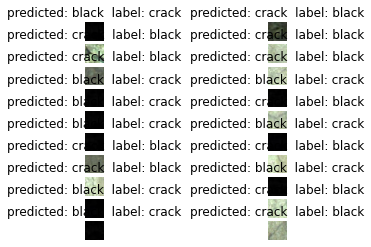

In [37]:
# 学習・検証を実行する
num_epochs=3
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)
visualize_model(net)

In [25]:
save_path = './weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)

In [71]:
load_path = './weights_fine_tuning.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)

<All keys matched successfully>

In [72]:
net = net.eval()

In [74]:
imsize = 50
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])
from torch.autograd import Variable #自動微分用


def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = transforms.Normalize(mean, std)(image)
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image  #assumes that you're using GPU  

for image_path in glob.glob('data/test/crack/*.jpg'):
    print(image_path)
    image = image_loader(image_path)
    # モデルに入力し、モデル出力をラベルに変換する
    out = net(image).cpu().data
    print(out)
    out_max = np.argmax(out.numpy())
    result = class_names[out_max]

    # 予測結果を出力する
    print("入力画像の予測結果：", result)

data/test/crack/cam1337338_21.jpg
tensor([[ 6.7995, -6.5870]])
入力画像の予測結果： crack
data/test/crack/cam0137300_1.jpg
tensor([[-3.6258,  3.1862]])
入力画像の予測結果： black
data/test/crack/cam0137311_1.jpg
tensor([[-4.0118,  3.7096]])
入力画像の予測結果： black
data/test/crack/cam1337338_13.jpg
tensor([[ 6.3530, -6.4732]])
入力画像の予測結果： crack
data/test/crack/cam1337337_8.jpg
tensor([[ 7.3774, -7.6213]])
入力画像の予測結果： crack
data/test/crack/cam1337337_20.jpg
tensor([[ 7.8321, -7.0156]])
入力画像の予測結果： crack
data/test/crack/cam0137261_4.jpg
tensor([[-3.9124,  3.3330]])
入力画像の予測結果： black
data/test/crack/cam1337337_2.jpg
tensor([[ 8.6844, -8.8432]])
入力画像の予測結果： crack
data/test/crack/cam0137274_2.jpg
tensor([[-2.7152,  2.2572]])
入力画像の予測結果： black
data/test/crack/cam1337334_31.jpg
tensor([[ 6.5014, -6.5307]])
入力画像の予測結果： crack
data/test/crack/cam0137334_7.jpg
tensor([[-3.8533,  3.3759]])
入力画像の予測結果： black
data/test/crack/cam1337337_11.jpg
tensor([[ 7.4362, -6.7545]])
入力画像の予測結果： crack
data/test/crack/cam0137310_2.jpg
tensor([[-3.94